# Knockout taxon 
* IMPORTANT: I modified and added function ["knockout_taxa2"] in package "community.py", "problems.py"
* So replace the original py files inside the micom packages with the modified py files (located in "/custom_pkg").


In [1]:
#install packages
# !pip install openpyxl==3.1.5
# !pip install micom==0.37.1
# !pip install pandas==2.3.3
# !pip install cobra==0.29.1
# !pip install seaborn


#import packages
import pandas as pd
from datetime import datetime
import pickle, openpyxl, cobra
import re, micom, os
import numpy as np
from micom.workflows import grow
from micom import Community, data
from micom import load_pickle
import warnings
import seaborn
from pathlib import Path
warnings.filterwarnings("ignore")

### Import data

In [2]:
# Input the community model to perform knockout simulation
model_name = "yunusbayev_genus_0.01"
model_directory = "models/"+  model_name


#phenotype
metadata = pd.read_csv("input/"+ "yunusbayev_metadata.csv")
phenotype_df = metadata["host_disease"]
phenotype_df.index = metadata["sample"]


#diet
from micom.qiime_formats import load_qiime_medium
medium = load_qiime_medium("database/western_diet_gut.qza")
medium_dict = medium["flux"].to_dict()


#---- Model simulation parameters ----
trade_off = 0.3
solver = "gurobi"
cpu_threads = 4

#output directory, don't change below
output_name = f"{model_name}_{trade_off}"

### Iterate into a whole series
* 1. Sample ID
* 2. Phenotype
* 3. Taxon that is deleted
* 4. Taxon that is affected
* 5. Growth rate of 4 before deletion of 3
* 6. Growth rate of 4 after deletion of 3
* 7. Absolute change of Growth rate of 4 after deletion of 3
* 8. Relative change of Growth rate of 4 after deletion of 3


I recreated the function of knockout_taxa -> knockout_taxa2 (check problem.py in micom lib)

In [3]:
if f"{output_name}_raw_ko.csv" in os.listdir("results_ko/"):
    print("This file is already simulated. No need to perform simulation and ending this code.")
    import sys
    sys.exit()


final_ko_df_col = ["sample","phenotype", "taxon_deleted", "taxon_affected", "gr_before", "gr_after", "change_abs", "change_rel"]
final_ko_df = pd.DataFrame(columns =final_ko_df_col)
models_list = list(Path( model_directory).iterdir())
models_list = [i for i in models_list if str(i).endswith(".pickle")]

#simulate for each sample
for model in models_list:
    
    sample_name = re.search(r"D.*profile",str(model))[0] #r"D.*profile" #r"SRR.*[0-9]"
    print(f"Now simulating: {sample_name}")
    print(datetime.now().strftime("%H:%M:%S"))
    print("\n")
    phenotype = phenotype_df[sample_name]
    indiv_model = load_pickle(model_directory+ "/"+sample_name+".pickle")
    indiv_model.medium = medium_dict
    
    indiv_model.cooperative_tradeoff() #############################
    before_change, after_change, absolute_change, relative_change = indiv_model.knockout_taxa2(fraction=trade_off, progress= True, method="relative change", diag=False)

    for taxon_deleted in before_change.index:

        # Iterating the taxons affected by a specific deleted_taxon
        for taxon_affected in before_change.columns:
            
            
            if taxon_affected != taxon_deleted: #filter out the same taxons
                before_gr = before_change.loc[taxon_deleted, taxon_affected]
                after_gr  = after_change.loc[taxon_deleted, taxon_affected]
                abs_gr    = absolute_change.loc[taxon_deleted, taxon_affected]
                rel_gr    = relative_change.loc[taxon_deleted, taxon_affected]

                #cram them all into a list
                temp_list = pd.Series([sample_name, phenotype, taxon_deleted, taxon_affected, before_gr, after_gr, abs_gr, rel_gr], index=final_ko_df_col)
                final_ko_df = pd.concat([final_ko_df, temp_list.to_frame().T], ignore_index=True)



#export the file
final_ko_df.to_csv(f"results_ko/{output_name}_raw_ko.csv", index=False)

This file is already simulated. No need to perform simulation and ending this code.


SystemExit: 

### Simulation Analysis 

In [4]:
abs_threshold = 0.1
rel_threshold = 2

#insert the simulated csv here
final_ko_df = pd.read_csv(f"results_ko/{output_name}_raw_ko.csv", index_col=False)

print(f"The total KO simulations: {len(final_ko_df)}")
sign_hits_abs = lambda X : len(final_ko_df[final_ko_df["change_abs"].abs() > X])
sign_hits_rel = lambda X : len(final_ko_df[final_ko_df["change_rel"].abs() > X])
percentage = lambda X : round((X/len(final_ko_df))*100,2 )
print(f"Number of KOs that had absolute change of over 0.05: {sign_hits_abs(0.5)} ({percentage(sign_hits_abs(0.05))} %)")
print(f"Number of KOs that had absolute change of over 0.1: {sign_hits_abs(0.1)} ({percentage(sign_hits_abs(0.1))} %)")
print(f"Number of KOs that had absolute change of over 0.2: {sign_hits_abs(0.2)} ({percentage(sign_hits_abs(0.2))} %)")
print()
print(f"Number of KOs that had relative change of over 2.0: {sign_hits_rel(2)} ({percentage(sign_hits_rel(2))} %)")
print()
gr_below = lambda X : len(final_ko_df[final_ko_df["gr_before"] < X])
print(f"Number of original taxon that had gr of less than 0.1: {gr_below(0.1)} ({percentage(gr_below(0.1))} %)")
print(f"Number of original taxon that had gr of less than 0.01: {gr_below(0.01)} ({percentage(gr_below(0.01))} %)")

The total KO simulations: 15080
Number of KOs that had absolute change of over 0.05: 57 (6.13 %)
Number of KOs that had absolute change of over 0.1: 482 (3.2 %)
Number of KOs that had absolute change of over 0.2: 195 (1.29 %)

Number of KOs that had relative change of over 2.0: 1285 (8.52 %)

Number of original taxon that had gr of less than 0.1: 12878 (85.4 %)
Number of original taxon that had gr of less than 0.01: 2805 (18.6 %)


### Plot the absolute gr change

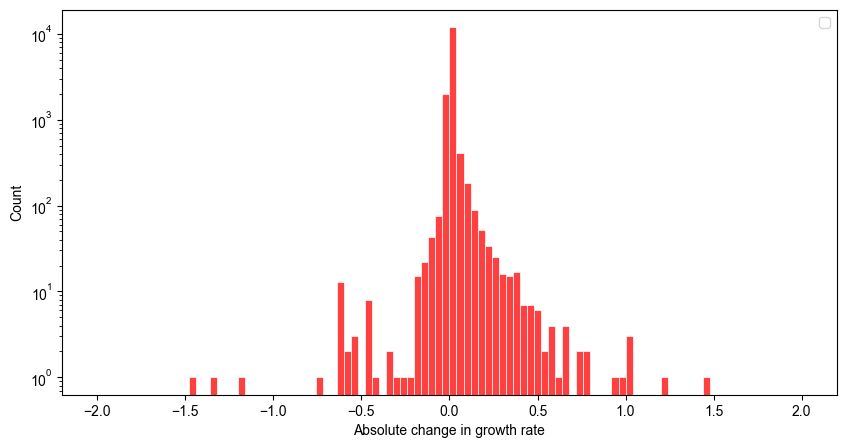

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
sns.set_style("whitegrid", {'grid.linestyle': '--', "grid.color": ".6"})
ax.grid(False, axis='x')


sns.histplot(
    data=final_ko_df,
    x="change_abs",
    binrange=(-2, 2),
    bins=100,
    log_scale=(False, False),
    color="red",
    ax=ax
)

# x,y axis
ax.set_yscale("log")
ax.set_xlabel("Absolute change in growth rate")

mean_val = final_ko_df["change_abs"].mean()
median_val = final_ko_df["change_abs"].median()
#ax.axvline(mean_val, linestyle=".", linewidth=1.5, label=f"Mean = {mean_val:.2e}")
#ax.axvline(median_val, linestyle="-.", linewidth=1.5, label=f"Median = {median_val:.2e}")
ax.legend()


## Interaction network construction
* Goal: unipartite graph where nodes represent microbial species and edges represent pairwise inter-species interactions
* The direction: Does the removal of taxon increase the gr (compete) or decrease (cooperate)
* Edges : The change of growth rates infer cooperation/competition


In [6]:
# ---- Set the parameters ----

#insert the simulated csv here
final_ko_df = pd.read_csv(f"results_ko/{output_name}_raw_ko.csv", index_col=False)

#parameters setting here
#============================================================================
absolute_threshold = 0.01 # the threshold for absolute growth rate change.
hits_threshold = 5 # threshold for minimum interactions
percentage_threshold = 0.0 # threshold for percentage of interactions required over absolute threshold 

#============================================================================
# function for filtering pairs that had at least certain percentage of hits
def contains_over_value(list, threshold):
    threshold = threshold
    total_hits = len(list)

    hits_plus = 0
    hits_minus = 0
    for i in list:
        if i > threshold: 
            hits_plus +=1 
        elif i < -threshold:
            hits_minus +=1
    if hits_plus > hits_minus:
        final = hits_plus/total_hits
    else:
        final = hits_minus/total_hits

    return final


# ---- Create the filtered interaction dataframe ----
total_taxon_pair = list(set(list(final_ko_df["taxon_deleted"] + final_ko_df["taxon_affected"]))) # ex index via [Alistipes_putredinisRoseburia_intestinalis]
processed_ko_df_col = ["taxon_deleted", "taxon_affected", "hits", "abs_sum", "rel_sum"]
processed_ko_df = pd.DataFrame(columns=processed_ko_df_col, index=total_taxon_pair).fillna(0)
processed_ko_df["abs_sum"] =[[] for i in processed_ko_df.index]


for index in final_ko_df.index:
    taxon_deleted  = final_ko_df.loc[index, "taxon_deleted"]
    taxon_affected = final_ko_df.loc[index, "taxon_affected"]
    rel_change = final_ko_df.loc[index, "change_rel"]
    abs_change = final_ko_df.loc[index, "change_abs"]


    taxon_index= taxon_deleted+taxon_affected
    processed_ko_df.loc[taxon_index,"taxon_deleted"] = taxon_deleted
    processed_ko_df.loc[taxon_index,"taxon_affected"] = taxon_affected
    processed_ko_df.loc[taxon_index,"hits"] += 1
    processed_ko_df.loc[taxon_index,"abs_sum"].append(abs_change)
    processed_ko_df.loc[taxon_index,"rel_sum"] += rel_change

#----Process average, median, std----
processed_ko_df["avg_abs"] = [pd.Series(processed_ko_df["abs_sum"][i]).mean() for i in processed_ko_df.index]  #average of gr
processed_ko_df["median_abs"] = [pd.Series(processed_ko_df["abs_sum"][i]).median() for i in processed_ko_df.index] #median of gr
quantile_mean =  lambda a : a[ (a >= a.quantile(0.25)) & (a <= a.quantile(0.75))].mean() #quantile mean
processed_ko_df["quant_abs"] = [quantile_mean(pd.Series(processed_ko_df["abs_sum"][i])) for i in processed_ko_df.index] #quantile mean of gr
processed_ko_df["std_abs"] = [pd.Series(processed_ko_df["abs_sum"][i]).std() for i in processed_ko_df.index] #std of average
processed_ko_df["coef_var"] = processed_ko_df["std_abs"] / processed_ko_df["avg_abs"] # coef of variation
#processed_ko_df["avg_rel"] = processed_ko_df["rel_sum"] / processed_ko_df["hits"]


processed_ko_df["abs_sum"] = [sorted([round(float(j),3) for j in processed_ko_df["abs_sum"][i]]) for i in processed_ko_df.index] #sorting out the values for each pairs
processed_ko_df["proportion"] = [contains_over_value(processed_ko_df["abs_sum"][i], absolute_threshold) for i in processed_ko_df.index]
processed_ko_df = processed_ko_df.sort_values(by="avg_abs")


#----final filteration based on the parameters----
# just choose one of the filtering standards
#============================================================================
# final_deduced_ko_df = processed_ko_df[(processed_ko_df["median_abs"].abs() > absolute_threshold) & (processed_ko_df["hits"] >=hits_threshold)]
# final_deduced_ko_df = processed_ko_df[(processed_ko_df["proportion"] >= 0.5) & (processed_ko_df["hits"] >=hits_threshold)]
final_deduced_ko_df = processed_ko_df[(processed_ko_df["proportion"] >= percentage_threshold) & (processed_ko_df["quant_abs"].abs() >=absolute_threshold) & (processed_ko_df["hits"] >=hits_threshold)]
#============================================================================


# ---- Create the summary interaction dataframe ----
#find unique taxa
unique_taxons = list(set(list(final_deduced_ko_df["taxon_deleted"].unique()) + list(final_deduced_ko_df["taxon_affected"].unique())))
unique_taxons = sorted(unique_taxons)

summary_df_col = [ "links", "competition", "cooperation"]
summary_df  = pd.DataFrame(columns = summary_df_col, index= unique_taxons)
summary_df["links"]= summary_df["links"].fillna(0)
summary_df["competition"]= summary_df["competition"].fillna("")
summary_df["cooperation"]= summary_df["cooperation"].fillna("")

for i in final_deduced_ko_df.index:
    taxon_del = final_deduced_ko_df.loc[i,"taxon_deleted"]
    taxon_aff = final_deduced_ko_df.loc[i,"taxon_affected"]
    gr_change = final_deduced_ko_df.loc[i,"quant_abs"]
    interact = "competition" if gr_change > 0 else "cooperation"

    if interact == "competition":
        summary_df.loc[taxon_del] += pd.Series([1, f"/{taxon_aff}",""], index = summary_df_col)
        summary_df.loc[taxon_aff] += pd.Series([1, f"/{taxon_del}",""], index = summary_df_col)

    else:
        summary_df.loc[taxon_del] += pd.Series([1, "",f"/{taxon_aff}"], index = summary_df_col)
        summary_df.loc[taxon_aff] += pd.Series([1,"", f"/{taxon_del}"], index = summary_df_col)

#remove /
summary_df["cooperation"] = summary_df["cooperation"].str.lstrip("/")
summary_df["competition"] = summary_df["competition"].str.lstrip("/")

# ---- export as xlsx ----
with pd.ExcelWriter(f"results_ko/{output_name}_interactions.xlsx") as writer:
    final_deduced_ko_df.to_excel(writer, sheet_name="Details", index=False) 
    summary_df.to_excel(writer, sheet_name="Summary", index=True)

## NetworkX
* Circular interactions map created using networkx, circular_layout
* Node color intensity infer the number of interactions with another taxa,
* This code was created using ChatGpt, so there may be errors

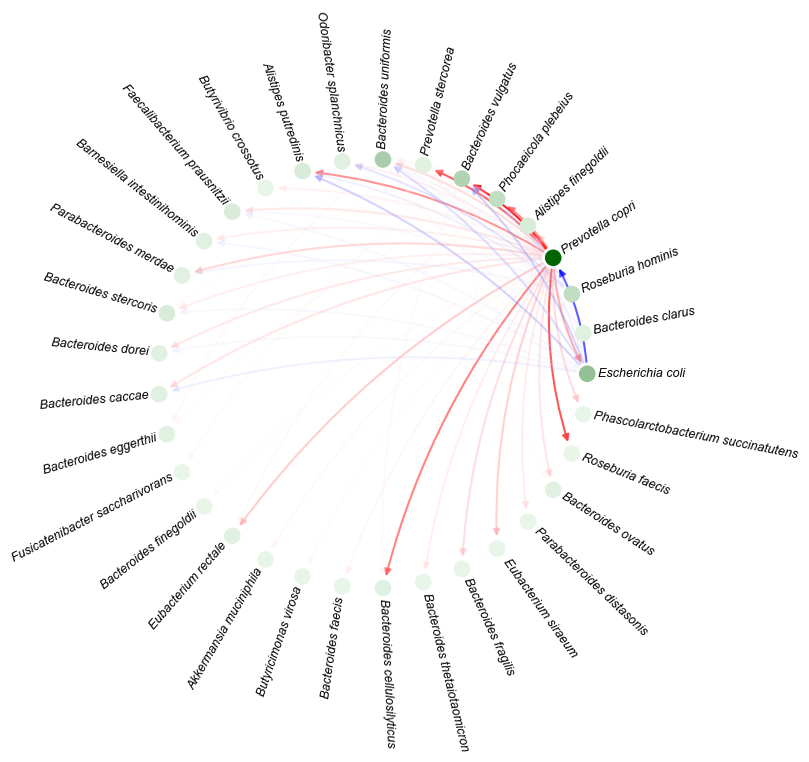

In [7]:
import pandas as pd, networkx as nx, numpy as np, matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import to_rgb
import random

# -----------------------------
# Data
# -----------------------------
interaction_df = pd.read_excel(f"results_ko/{output_name}_interactions.xlsx", sheet_name ="Details")

df = interaction_df
df["taxon_deleted"] = df["taxon_deleted"].str.replace("_", " ")
df["taxon_affected"] = df["taxon_affected"].str.replace("_", " ")


nodes = pd.concat([df["taxon_deleted"], df["taxon_affected"]]).dropna().unique().tolist()

seed = 0
random.seed(seed); np.random.seed(seed)

# -----------------------------
# Directed graph (deleted -> affected)
# -----------------------------
G = nx.DiGraph(); G.add_nodes_from(nodes)
for i in df.index:
    u, v = df.iloc[i, 0], df.iloc[i, 1]
    
    #this is based on the quantile mean avg
    cg = df.iloc[i, 7] 
    G.add_edge(u, v,
               weight=abs(cg),
               kind=("Competition" if cg > 0 else "Cooperation"),
               change_gr=cg)

# Circle radius = 180
scale = 180.0
pos = nx.circular_layout(G, scale=scale)

# -----------------------------
# Edge styling (alpha from weight) + color range [-0.2, 0.2]
# -----------------------------
edges_comp = [(u, v) for u, v, d in G.edges(data=True) if d["kind"] == "Competition"]
edges_coop = [(u, v) for u, v, d in G.edges(data=True) if d["kind"] == "Cooperation"]

ws = np.array([d["weight"] for _, _, d in G.edges(data=True)]) if G.number_of_edges() else np.array([])
alpha_map = (
    {e: (0.2 + 0.8 * ((w - ws.min()) / (ws.max() - ws.min() + 1e-12))) for e, w in zip(G.edges(), ws)}
    if ws.size else {}
)

# --- NEW: color map limited to change_gr in [-0.2, 0.2] ---
cmap = plt.get_cmap("bwr")  # blue-white-red diverging map
#color intensity
norm = mcolors.TwoSlopeNorm(vmin=-0.1, vcenter=0.0, vmax=0.2)

def edge_color(e):
    cg = G.edges[e]["change_gr"]           # original signed value
    base = cmap(norm(cg))                  # map to color using [-0.2, 0.2]
    a = alpha_map.get(e, 0.6)              # keep your alpha logic
    return (base[0], base[1], base[2], a)  # replace alpha with ours

comp_colors = [edge_color(e) for e in edges_comp]
coop_colors = [edge_color(e) for e in edges_coop]



# -----------------------------
# Node colors by degree (light→dark green); FIXED node size
# -----------------------------
nodes_list = list(G.nodes())

deg = np.array([G.degree(n) for n in nodes_list])
deg_norm = (deg - deg.min()) / (deg.max() - deg.min() + 1e-12)

light = np.array(to_rgb("#E8F5E9"))   # LightGreen
dark  = np.array(to_rgb("#006400"))   # DarkGreen
node_colors = [tuple(light*(1 - t) + dark*t) + (1.0,) for t in deg_norm]

node_size = 120  # fixed size for all nodes

# -----------------------------
# Draw nodes & edges
# -----------------------------
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, nodelist=nodes_list, node_color=node_colors, node_size=node_size)

common = dict(arrows=True, arrowstyle='-|>', arrowsize=10,
              connectionstyle='arc3,rad=0.12', width=1.5)
nx.draw_networkx_edges(G, pos, edgelist=edges_comp, edge_color=comp_colors, **common)
nx.draw_networkx_edges(G, pos, edgelist=edges_coop, edge_color=coop_colors, **common)

# -----------------------------
# Labels radial (vertical to node), no stick
# -----------------------------

labels = {n: str(n) for n in nodes_list}

offset = 0.050 * scale  # distance from node along radial direction

for n, (x, y) in pos.items():
    a = np.arctan2(y, x)                 # radial angle (radians)
    ca, sa = np.cos(a), np.sin(a)

    # place text outward from node
    tx = x + offset * ca
    ty = y + offset * sa

    # rotate text along the radius (upright)
    rot = np.degrees(a)
    if rot > 90 or rot < -90:
        rot += 180  # keep readable orientation

    ha = "left" if ca >= 0 else "right"
    va = "center"

    plt.text(
        tx, ty, labels[n],
        fontsize=9, color="black", fontstyle="italic",
        rotation=rot, rotation_mode="anchor",
        ha=ha, va=va,
        bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.6),
    )


# -----------------------------
# Finish
# -----------------------------
plt.gca().set_aspect('equal', adjustable='datalim')
plt.axis("off")
plt.tight_layout()
plt.show()
